<a href="https://colab.research.google.com/github/vanithakattumuri/PAMI/blob/main/notebooks/partialPeriodicPattern/topk/k3PMiner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finding Top-K Partial Periodic Frequent patterns in Temporal Databases using k3PMiner

This tutorial has two parts. In the first part, we describe the basic approach to find Top-K Partial Periodic Frequent patterns in a temporal database using the k3PMiner algorithm. In the final part, we describe an advanced approach, where we evaluate the k3PMiner algorithm on a dataset at different minimum support threshold values.
***

# Prerequisites:

1.   Installing the PAMI library

In [1]:
!pip install -U pami #install the pami repository

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 835.0/835.0 kB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for JsonForm: filename=JsonForm-0.0.2-py3-none-any.whl size=3313 sha256=5c8a1ce58a3e12ec7b6bdaa7281dce6d7eade31475208865f94c3cd612f1f6ff
  Stored in directory: /root/.cache/pip/wheels/b6/e5/87/11026246d3bd4ad67c0615682d2d6748bbd9a40ac0490882bd
  Created wheel for JsonSir: filename=JsonSir-0.0.2-py3-none-any.whl size=4750 sha256=71e0677ab6d53ca8518569d16bf21541dc67a7ccb9c19af74b1262695bd8f848
  Stored in directory: /root/.cache/pip/wheels/1d/4c/d3/4d9757425983b43eb709be1043d82cd03fb863ce5f56f117e6
Successfully built JsonForm JsonSir


2.   Downloading a sample dataset

In [1]:
!wget -nc https://u-aizu.ac.jp/~udayrage/datasets/temporalDatabases/Temporal_T10I4D100K.csv #download a sample temporal database

--2023-09-07 08:23:20--  https://u-aizu.ac.jp/~udayrage/datasets/temporalDatabases/Temporal_T10I4D100K.csv
Resolving u-aizu.ac.jp (u-aizu.ac.jp)... 150.95.161.176, 150.31.244.160
Connecting to u-aizu.ac.jp (u-aizu.ac.jp)|150.95.161.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4606762 (4.4M) [text/csv]
Saving to: ‘Temporal_T10I4D100K.csv’

Temporal_T10I4D100K 100%[===================>]   4.39M  1.19MB/s    in 3.7s    

2023-09-07 08:23:25 (1.19 MB/s) - ‘Temporal_T10I4D100K.csv’ saved [4606762/4606762]



3.   Printing few lines of a dataset to know its format.

In [2]:
!head -2 Temporal_T10I4D100K.csv

1	25	52	164	240	274	328	368	448	538	561	630	687	730	775	825	834
2	39	120	124	205	401	581	704	814	825	834


format: every row contains items seperated by a seperator.

Example:

item1 item2 item3 item4

item1 item4 item6
***

## Part 1: Finding Top-K Partial Periodic Frequent patterns using k3PMiner

### Step 1: Understanding the statistics of a database to choose an appropriate minimum support (minSup) value.

In [3]:
#import the class file
import PAMI.extras.dbStats.temporalDatabaseStats as stats

#specify the file name
inputFile = 'Temporal_T10I4D100K.csv'

#initialize the class
obj=stats.temporalDatabaseStats(inputFile,sep='\t')

#execute the class
obj.run()

#Printing each of the database statistics
print(f'Database size : {obj.getDatabaseSize()}')
print(f'Total number of items : {obj.getTotalNumberOfItems()}')
print(f'Database sparsity : {obj.getSparsity()}')
print(f'Minimum Transaction Size : {obj.getMinimumTransactionLength()}')
print(f'Average Transaction Size : {obj.getAverageTransactionLength()}')
print(f'Maximum Transaction Size : {obj.getMaximumTransactionLength()}')
print(f'Standard Deviation Transaction Size : {obj.getStandardDeviationTransactionLength()}')
print(f'Variance in Transaction Sizes : {obj.getVarianceTransactionLength()}')

#saving the distribution of items' frequencies and transactional lengths
itemFrequencies = obj.getSortedListOfItemFrequencies()
transactionLength = obj.getTransanctionalLengthDistribution()
obj.save(itemFrequencies, 'itemFrequency.csv')
obj.save(transactionLength, 'transactionSize.csv')

#Alternative apporach to print all of the database statistics and plot them
# obj.printStats()
# obj.plotGraphs()

Database size : 99913
Total number of items : 870
Database sparsity : 0.9883887027691103
Minimum Transaction Size : 1
Average Transaction Size : 10.10182859087406
Maximum Transaction Size : 29
Standard Deviation Transaction Size : 3.667115963877195
Variance in Transaction Sizes : 13.447874088362232


### Step 2: Draw the item's frequency graph and transaction length's distribution graphs for more information

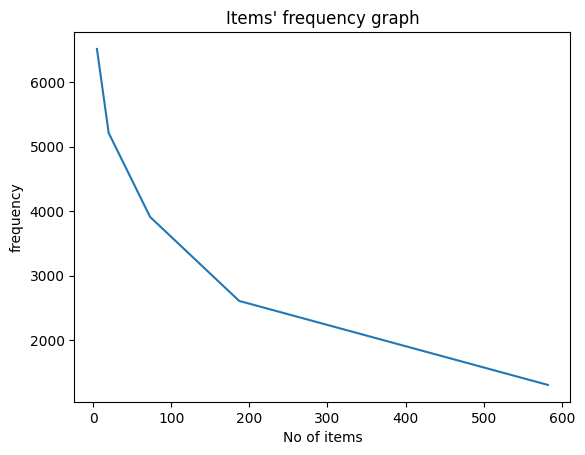

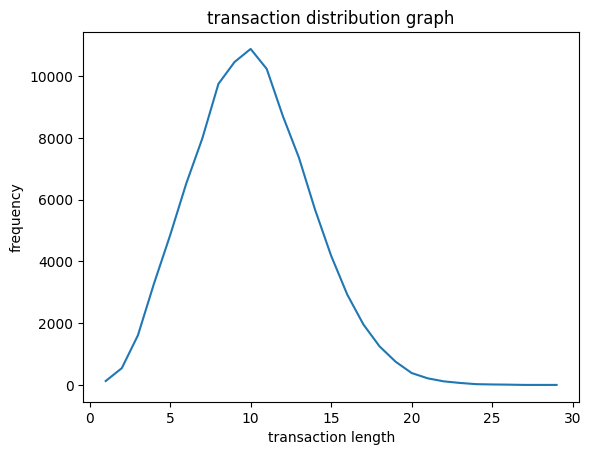

In [4]:
import PAMI.extras.graph.plotLineGraphFromDictionary as plt

itemFrequencies = obj.getFrequenciesInRange()
transactionLength = obj.getTransanctionalLengthDistribution()
plt.plotLineGraphFromDictionary(itemFrequencies, end = 100, title = 'Items\' frequency graph', xlabel = 'No of items', ylabel= 'frequency')
plt.plotLineGraphFromDictionary(transactionLength, end = 100, title = 'transaction distribution graph', xlabel = 'transaction length', ylabel = 'frequency')

### Step 3: Choosing an appropriate *minSup* value

_Observations_

  1. The input dataset is sparse as the sparsity value is 0.988 (=98.8%)
  2. Many items have low frequencies as seen in the items' frequency graph
  3. The dataset is not high dimensional as the inverted curve is around 10.

  Based on the above observations, let us choose a _minSup_ value of 100 (in count). We can increase or decrease the _minSup_ based on the number of patterns being generated.

In [5]:
minimumSupportCount = 100  #minSup is specified in count. However, the users can also specify minSup between 0 and 1.
PeriodCount = 5000  #PeriodCount is specified in count. However, the users can also specify PeriodCount between 0 and 1.

### Step 4: Mining Top-K Partial Periodic Frequent patterns using k3PMiner

In [6]:
from PAMI.partialPeriodicPattern.topk import k3PMiner  as alg #import the algorithm

obj = alg.k3PMiner(iFile=inputFile, k=minimumSupportCount, period=PeriodCount, sep='\t') #initialize
obj.startMine()            #start the mining process

obj.save('topKPartialPeriodicFrequentPatternsAtMinSupCount100.txt') #save the patterns


frequentPatternsDF= obj.getPatternsAsDataFrame() #get the generated frequent patterns as a dataframe
print('Total No of patterns: ' + str(len(frequentPatternsDF))) #print the total number of patterns
print('Runtime: ' + str(obj.getRuntime())) #measure the runtime

print('Memory (RSS): ' + str(obj.getMemoryRSS()))
print('Memory (USS): ' + str(obj.getMemoryUSS()))

TopK partial periodic patterns were generated successfully
Total No of patterns: 100
Runtime: 2.376168966293335
Memory (RSS): 253939712
Memory (USS): 205508608


### Step 5: Investigating the generated patterns

Open the pattern's file and investigate the generated patterns. If the generated patterns were interesting, use them; otherwise, redo the Steps 3 and 4 with a different _minSup_ value.

In [7]:
!head 'topKPartialPeriodicFrequentPatternsAtMinSupCount100.txt'

937:4675 
914:4036 
966:3918 
919:3705 
947:3688 
956:3622 
895:3380 
918:3007 
944:2790 
93:2774 


The storage format is: _topKPartialPeriodicfrequentPattern:support_
***

## Part 2: Evaluating the k3PMiner algorithm on a dataset at different minSup values

### Step 1: Import the libraries and specify the input parameters

In [8]:
#Import the libraries
from PAMI.partialPeriodicPattern.topk import k3PMiner as alg #import the algorithm
import pandas as pd

#Specify the input parameters
inputFile = 'Temporal_T10I4D100K.csv'
seperator='\t'
PeriodCount = 5000
minimumSupportCountList = [100, 150, 200, 250, 300]
#minimumSupport can also specified between 0 to 1. E.g., minSupList = [0.005, 0.006, 0.007, 0.008, 0.009]

### Step 2: Create a data frame to store the results of k3PMiner

In [9]:
result = pd.DataFrame(columns=['algorithm', 'minSup', 'PeriodCount', 'patterns', 'runtime', 'memory'])
#initialize a data frame to store the results of k3PMiner algorithm

### Step 3: Execute the algorithm at different minSup values

In [10]:
for minSupCount in minimumSupportCountList:
    obj = alg.k3PMiner(iFile=inputFile, k=minSupCount, period=PeriodCount, sep=seperator)
    obj.startMine()
    #store the results in the data frame
    result.loc[result.shape[0]] = ['k3PMiner', minSupCount, PeriodCount, len(obj.getPatterns()), obj.getRuntime(), obj.getMemoryRSS()]

TopK partial periodic patterns were generated successfully
TopK partial periodic patterns were generated successfully
TopK partial periodic patterns were generated successfully
TopK partial periodic patterns were generated successfully
TopK partial periodic patterns were generated successfully


### Step 4: Print the Result

In [11]:
print(result)

  algorithm  minSup  PeriodCount  patterns    runtime     memory
0  k3PMiner     100         5000       100   2.483504  266457088
1  k3PMiner     150         5000       150   3.455439  266907648
2  k3PMiner     200         5000       200   6.762334  267304960
3  k3PMiner     250         5000       250   8.694199  267083776
4  k3PMiner     300         5000       300  14.277166  267206656


### Step 5: Visualizing the results

<Axes: xlabel='minSup'>

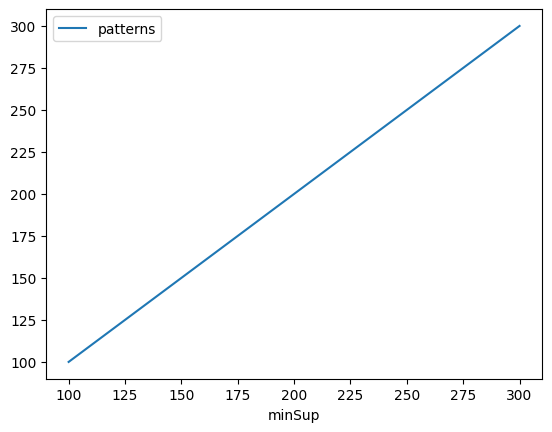

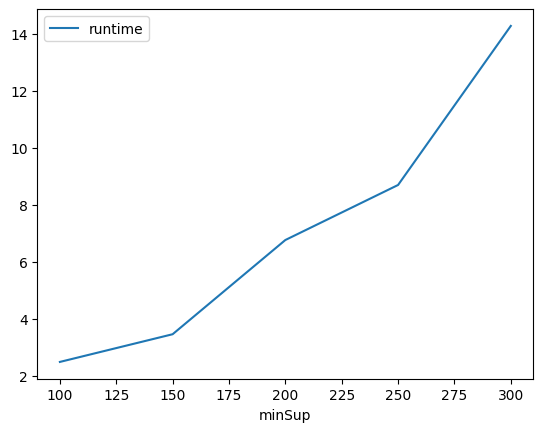

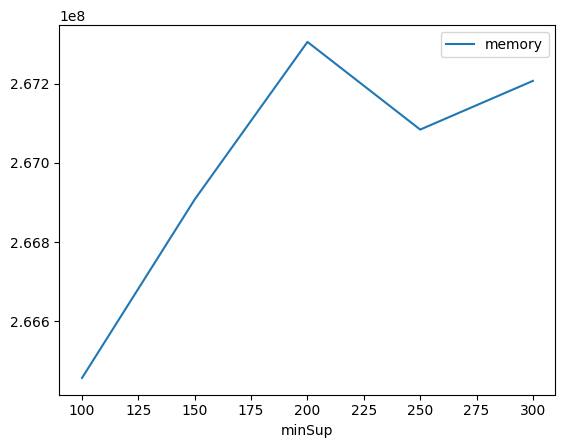

In [12]:
result.plot(x='minSup', y='patterns', kind='line')
result.plot(x='minSup', y='runtime', kind='line')
result.plot(x='minSup', y='memory', kind='line')

#Graphs can be improved further by using additional packages, such as plotly and matplotlib